In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.fftpack as fft
import seaborn as sns
# from mpl_toolkits import basemap
import geopandas
import cartopy
pd.options.display.max_columns = 999
pd.options.display.max_rows = 77
from shapely.geometry import Point
import shapely.ops as shops

%matplotlib inline

In [2]:
def read_data(filename, usecols=[2, 5, 8, 19, 20], dtype={'Primary Type': str, 'Arrest': bool, 'Latitude' : float, 'Longitude' : float}, **kwargs):

    data = pd.read_csv(filename, usecols=usecols, dtype=dtype, quotechar='"', index_col='Date', **kwargs)
    data.index = pd.to_datetime(data.index, format='%m/%d/%Y %I:%M:%S %p')
    return data

In [3]:
def add_counts(crime_df, crime_type=None):
    """Add the counts by function of hour, day, month, and year
    
    If crime_type is None, then all crimes. Otherwise, for crime_type only"""
    
    crime_count_dict = {}
    
    if crime_type is not None and str.lower(crime_type) != 'all':
        crime_df = crime_df[crime_df['Primary Type'] == str.upper(crime_type)]
    
    if len(crime_df) == 0:
        raise KeyError('Invalid crime type')
    
    crime_count_dict['hour'] = crime_df.index.hour.value_counts().astype(float)
    crime_count_dict['weekday'] = crime_df.index.weekday.value_counts().astype(float)
    crime_count_dict['day'] = crime_df.index.day.value_counts().astype(float)
    crime_count_dict['month'] = crime_df.index.month.value_counts().astype(float)
    crime_count_dict['year'] = crime_df.index.year.value_counts().astype(float)
    
    return crime_count_dict

In [4]:
def plot_counts(counts, ax, weights=None, bar=True, do_err=False, **kwargs):
    """Provide bar position and heights for crime counts
    
    if weights is not None, weightsalize 
    If bar false, do a line plot
    """
    xs = counts.index
    vals = counts.values / counts.values.sum()
    
    if weights is not None:
        try:
            vals *= weights
        except TypeError:
            if weights.lower() == 'month':
                weights = 1. / np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) * 30. 
                #technically Feb is 28.25?
            elif weights.lower() == 'day':
                weights = np.ones(31)
                weights[30] = 12./7
                weights[29] = 12./11
                weights[28] = 12./11
            else:
                print(f'Unrecognized weights: {weights}')
                weights = np.ones(len(xs))
            assert len(weights) == len(xs)
            vals *= weights
    if bar:
        ax.bar(xs, vals, **kwargs)
    else:
        if do_err:
            ax.errorbar(np.sort(xs), vals[np.argsort(xs)], yerr=np.sqrt(counts.values)/counts.values.sum(), **kwargs)
        else:
            ax.plot(np.sort(xs), vals[np.argsort(xs)], **kwargs)

In [86]:
def spread_annotations(xys, geo_df):
    """Given list of (x, y) values, returns distributed (x, y) values for placing text label
    
    xys : the list of (x, y) values
    geo_df : the geopandas dataframe
    """
    
    xys = np.array(xys)
    shape = xys.shape
    try:
        x, y = xys
    except ValueError:
        x, y = xys.transpose()
        
    tot_map = shops.cascaded_union(geo_df.geometry)
    tot_map = tot_map.convex_hull
    new_x, new_y = [], []
    for ix, iy in zip(x, y):
        near_points = shops.nearest_points(Point(ix, iy), tot_map.boundary)
        centroid_point = near_points[0].bounds[0], near_points[0].bounds[1]
        edge_point = [near_points[1].bounds[0], near_points[1].bounds[1]]
        
        if abs(edge_point[1] - tot_map.bounds[3]) < 0.02:
            edge_point[1] += 0.02
        elif abs(edge_point[1] - tot_map.bounds[1]) < 0.02:
            edge_point[1] -= 0.02
        if tot_map.intersects(Point(edge_point[0] + 0.05, edge_point[1])):
            edge_point[0] -= 0.05
        else:
            edge_point[0] += 0.05
        
        
        new_x.append(edge_point[0])
        new_y.append(edge_point[1])
    
    return np.array(new_x), np.array(new_y)

In [62]:
def plot_crime_map(crime_df, geo_df, census_df, year, crime_type, cmap='Blues', annotate=False,
                  num_annotations=(3, 3)):
    """Plot the crime rate by neighborhood
    
    crime_df : the crime dataframe
    geo_df : the geopandas dataframe, for drawing the map
    census_df : the census dataframe
    year : either one year or a range of years, inclusively, (min_year, max_year)
    crime_type : the type of crime to consider
    cmap (default 'Blues') : the colormap to use
    annotate (default False) : whether to label the highest and/or lowest crime neighborhoods, using
        the remaining arguments as guide
    num_annotations (default (3, 3)) : 2-tuple with (num_low, num_high), the number of neighborhoods to
        label with the lowest and highest crime rates, respectively
    """
    
    try:
        a = len(year)
    except TypeError:
        year = [year]
    
    if len(year) == 1:
        subview = crime_df.loc[crime_df['Year'] == year[0]]
    elif len(year) == 2:
        subview = crime_df.loc[(crime_df['Year'] >= year[0]) & (crime_df['Year'] <= year[1])]
    else:
        raise ValueError('Too many years!')
        
    neighborhood_counts = (subview[subview['Primary Type'] == crime_type.upper()]['Community Area']
                                                .value_counts(sort=False))
    neighborhood_counts = neighborhood_counts.reindex(index=geo_df['area_num_1'].astype(int), fill_value=0)
    neighborhood_rates = (1e5 * neighborhood_counts / census_df['Total Population'] / len(subview['Year']
                                                .value_counts()))

    cmap1 = plt.cm.ScalarMappable(cmap=cmap)
    cmap1.set_clim(0, neighborhood_rates.max())

    ax = geo_df.plot(edgecolor='k', 
                    facecolor=cmap1.to_rgba(neighborhood_rates.loc[geo_df['area_num_1'].astype(int)]), 
                    figsize=(10, 10))
    
    fig = ax.get_figure()
    cax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
    cbar = fig.colorbar(cmap1, cax=cax)
    if len(year) > 1:
        year_label = f'{year[0]} to {year[1]}'
    else:
        year_label = f'{year[0]}'
    cbar.set_label(f'{crime_type.title()} per 100k people, ' + year_label, rotation=270, fontsize=20, labelpad=20)
    ax.set_xlim([-88, -87.5])
    ax.set_ylim([41.6, 42.05])
    
    if annotate:
        # lowest crime rate not necessarily unique if there are multiple zeros
        annotate_inds = []
        annotate_inds += list(np.arange(num_annotations[0]))
        annotate_inds += list(np.arange(-num_annotations[1], 0))
        to_annotate = neighborhood_rates.sort_values().iloc[annotate_inds]
        if len(to_annotate) > 0:
            # location of neighborhood centers
            xys = np.array([[geo_df[geo_df['area_num_1'] == neighborhood].centroid.x.values[0], 
                   geo_df[geo_df['area_num_1'] == neighborhood].centroid.y.values[0]]
                   for neighborhood in to_annotate.index])
            # where to place the labels
            new_x, new_y = spread_annotations(xys, geo_df)
            for i, (x, y) in enumerate(xys):
    #             ax.text(x, y, geo_df[geo_df['area_num_1'] == to_annotate.index[i]]['community'].values[0].title())
                ax.annotate(geo_df[geo_df['area_num_1'] == to_annotate.index[i]]['community'].values[0].title(),
                           xy=(x, y), xytext=(new_x[i], new_y[i]),
                           arrowprops=dict(arrowstyle='-'))

In [7]:
nrows = None
filename = '/home/elaad/Documents/Fun/DatAnalysis/datasets/Crimes_-_2001_to_present.csv'
crimedata = read_data(filename, nrows=nrows, usecols=None, dtype=None)
print(len(crimedata[crimedata.Longitude <= -90]))
crimedata = crimedata[crimedata.Longitude > -90] # getting rid of a few unexpected outliers beyond the city limits
crimedata.sort_index(inplace=True)

/home/elaad/miniconda3/envs/chicago/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


163


In [8]:
census_dat = pd.read_excel('/home/elaad/Documents/Fun/DatAnalysis/datasets/CCASF12010CMAP.xlsx',
                          index_col=1, header=1, skiprows=0)

# Overview

What are the most common crimes?

In [9]:
crimedata['Primary Type'].value_counts()

THEFT                                1470315
BATTERY                              1280246
CRIMINAL DAMAGE                       796802
NARCOTICS                             716655
ASSAULT                               438973
OTHER OFFENSE                         433657
BURGLARY                              397221
MOTOR VEHICLE THEFT                   321084
DECEPTIVE PRACTICE                    272643
ROBBERY                               263086
CRIMINAL TRESPASS                     199838
WEAPONS VIOLATION                      77023
PROSTITUTION                           68410
PUBLIC PEACE VIOLATION                 49231
OFFENSE INVOLVING CHILDREN             45584
CRIM SEXUAL ASSAULT                    27487
SEX OFFENSE                            25276
INTERFERENCE WITH PUBLIC OFFICER       16712
GAMBLING                               14470
LIQUOR LAW VIOLATION                   14178
ARSON                                  11488
HOMICIDE                                9961
KIDNAPPING

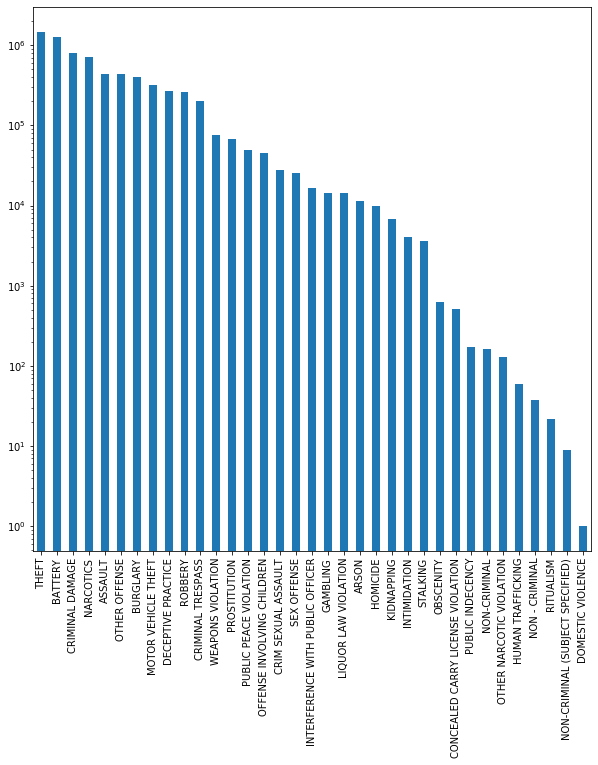

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
crimedata['Primary Type'].value_counts().plot(kind='bar', ax=ax)
ax.set_yscale('log')

So, thefts are the most common crime, followed by battery. This is not terribly surprising. Of, say, thefts, what are the most common descriptors?

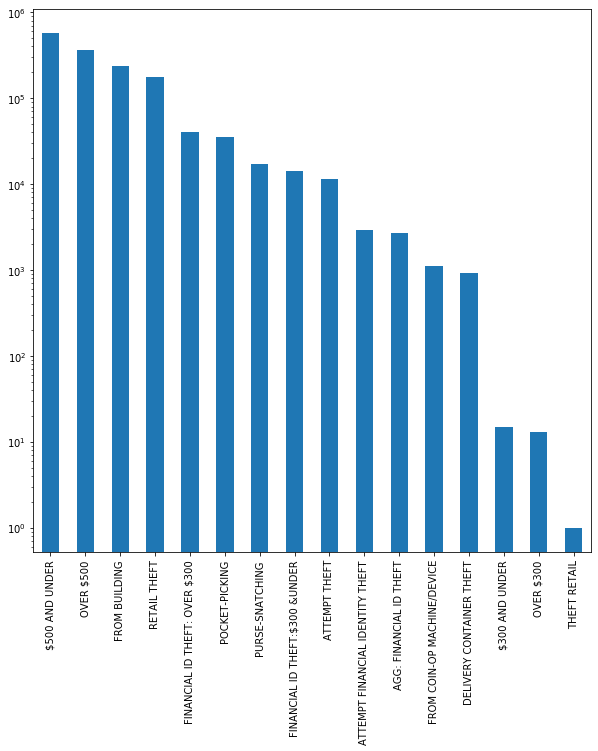

In [11]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
crimedata[crimedata['Primary Type'] == 'THEFT']['Description'].value_counts().plot(kind='bar', ax=ax)
ax.set_yscale('log')

The most common theft description is \\$500 and under, followed by over \\$500; small amounts are more common than large. For Financial ID Theft, however, it is the other way around, with higher amounts more common.

Retail theft has one reported incidence; I should look into this. Under-reporting, or inconsistent descriptor?

# Crimes as a function of time and date

Some assumptions certainly go into the believability of these plots.
For example:
* Listed information---particularly dates and times---are accurate (the overabundance of crimes on the first of the month casts doubt on this assumption)

In [12]:
crime_counts = {}
for crime_type in ['all', 'homicide', 'theft']:
    crime_counts[crime_type] = add_counts(crimedata, crime_type)

Unrecognized weights: hour
Unrecognized weights: hour
Unrecognized weights: hour
Unrecognized weights: weekday
Unrecognized weights: weekday
Unrecognized weights: weekday
Unrecognized weights: year
Unrecognized weights: year
Unrecognized weights: year


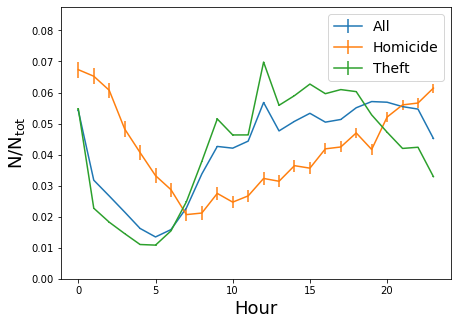

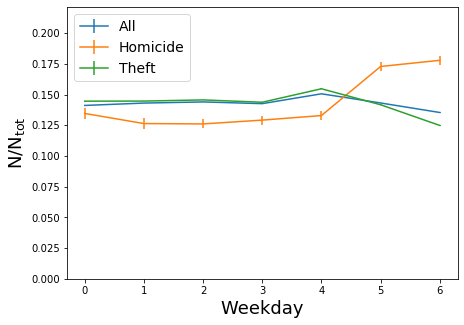

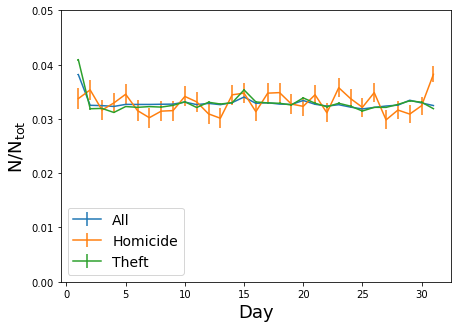

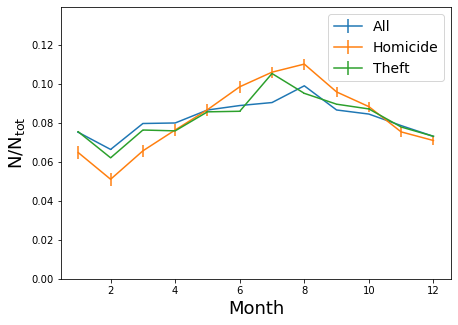

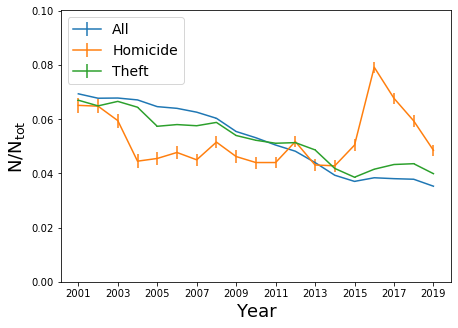

In [13]:
for time_interval in crime_counts['all']:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)
    for crime_type, color, hatch in zip(crime_counts, [f'C{i}' for i in range(len(crime_counts))],
                                ['//', '\\\\', '--']):
        plot_counts(crime_counts[crime_type][time_interval], ax, weights=time_interval, bar=False, do_err=True,
                    label=crime_type.capitalize(), color=color,)# alpha=1./len(crime_counts),)
#                     hatch=hatch)
    ax.legend(loc='best', fontsize=14)
    ax.set_xlabel(time_interval.capitalize(), fontsize=18)
    ax.set_ylabel('N/N$_\mathrm{tot}$', fontsize=18)
    ax.set_ylim([0, ax.set_ylim()[-1] * 1.2])
    if time_interval == 'year':
        ax.set_xticklabels([str(year) for year in np.arange(2001, 2021, 2)])
        ax.set_xticks(np.arange(2001, 2021, 2))

A few interesting things to note here. Crimes generally seem to be least frequent around 5 AM, while homicides bottom out around 7 AM. Homicides also seem to peak a bit later than most crimes. Thefts, on the other hand, peak in the afternoon (except for a single spike around noon, which I will assume for now comes from thefts around the lunch hour. To test this I should see which specific types of theft are contributing to the spike). All of these observations are consistent with a general idea that most crimes require people to be around, while homicides occure when people *aren't* around.

There aren't strong trends with day of the week, except for a weekday/weekend divide. Homicides are less common on weekdays and more common on weekends, while other crimes are generally more common during the week. Future work will require separating crimes geographically. How much of this trend comes from crimes being concentrated in business areas?

For day of the month, I have weighted the histograms so that long months have their extra days' counts proportionately increased. With the exception of the first and last day of the month, variations look like noise. I assume (for now) that the differences in the first/last days are reporting biases of some sort.

For month of year, I have also weighted months by their length, so I have upweighted February and downweighted long months.

Crime generally has gone down over the last 19 years, almost by a factor of 2. The decline may be leveling, however. Starting in 2015, as well, murders spiked significantly, though perhaps they are returning again to their previous levels.

# Where do crimes occur?

In [14]:
geodf = geopandas.read_file('../datasets/Boundaries_Community_Areas/')
geodf['area_num_1'] = geodf['area_num_1'].astype(int)

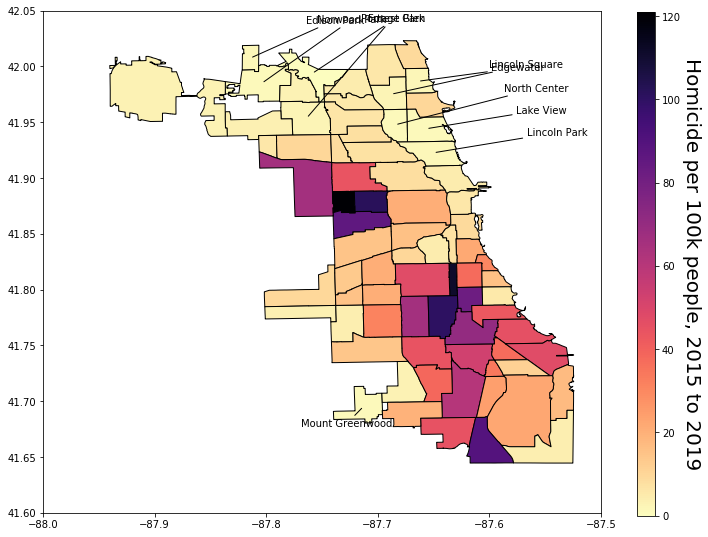

In [87]:
plot_crime_map(crimedata, geodf, census_dat, (2015, 2019), 'homicide', cmap='magma_r', 
               annotate=True, num_annotations=(10, 0))

In [16]:
subview = crimedata.loc[crimedata['Year'] == 2019]
neighborhood_counts = subview[subview['Primary Type'] == 'HOMICIDE']['Community Area'].value_counts(sort=False)
neighborhood_counts = neighborhood_counts.reindex(index=geodf['area_num_1'].astype(int), fill_value=0)
neighborhood_rates = 1e5 * neighborhood_counts / census_dat['Total Population'] / len(subview['Year'].value_counts())

In [75]:
cmap1 = plt.cm.ScalarMappable(cmap='Blues')
cmap1.set_clim(0, neighborhood_rates.max())

To do -- make a gif of this over time (murder rate per year...)

Anyway -- here were the neighborhoods with the most murders in 2019

(41.6, 42.05)

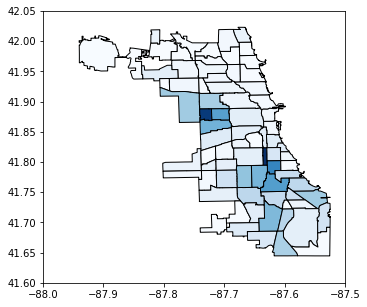

In [152]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, )

geodf.plot(edgecolor='k', facecolor=cmap1.to_rgba(neighborhood_rates.loc[geodf['area_num_1'].astype(int)]), 
               ax=ax, legend=True, legend_kwds={'orientation' : 'horizontal'})
# fig = ax.get_figure()
cax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
# cbar = fig.colorbar(cmap1)
# years = subview['Year'].value_counts().index
if len(years) > 1:
    year_label = f'{subview["Year"].value_counts().index.min()} to {subview["Year"].value_counts().index.max()}'
else:
    year_label = f'{subview["Year"].value_counts().index[0]}'
cbar.set_label(f'Murders per 100k people, ' + year_label, rotation=270, fontsize=20, labelpad=20)
ax.set_xlim([-88, -87.5])
ax.set_ylim([41.6, 42.05])

In [155]:
crimedata[crimedata['Primary Type'] == 'HOMICIDE'].Longitude.min()

-87.846467101

# Do crimes behave as a Poisson process? - Not Done

Let's use 2007 as a "typical" year, since it's in the middle of a steady homicide rate.

Caveat -- assumes accurate reporting times

In [ ]:
crimes2007 = crimedata[crimedata.index.year==2007]
for crimetype in ['HOMICIDE', 'THEFT', 'BATTERY']:
    subset2007 = crimes2007[crimes2007['Primary Type']==crimetype]
    subset_mean = len(subset2007)/365.0
    print('There were an average of {:.2f} '.format(subset_mean)+crimetype+' crimes per day in 2007')
    subset_counts2007 = subset2007.index.dayofyear.value_counts()

    fig, ax = plt.subplots(1, 1)
    if len(subset2007)>1000.0:
        bins = np.arange(subset_counts2007.min()-1.5, subset_counts2007.max()+1.5, 2.0)
    else:
        bins = np.arange(subset_counts2007.min()-1.5, subset_counts2007.max()+1.5, 1.0)
    ax.hist(subset_counts2007.values, bins=bins, label='Actual Counts')
    ax.plot(bins+0.5, 365.0*ss.poisson.pmf(bins+0.5, subset_mean), 'o', label='Poisson')
    ax.set_xlabel(crimetype+' Per Day')
    ax.set_ylabel('Count')
    plt.legend(loc='best')

# FFT - Not done

In [ ]:
crime_days = (crimedata.index - pd.to_datetime('Jan 01 2001')).days.value_counts().sort_index()
homicide_days = (crimedata[crimedata['Primary Type'] == 'HOMICIDE'].index - 
                 pd.to_datetime('Jan 01 2001')).days.value_counts().sort_index()

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(crime_days/crime_days.sum())
ax.plot(homicide_days/homicide_days.sum()+0.00025)

In [ ]:
homicide_fft = fft.fft(homicide_days.values)
homicide_freq = fft.fftfreq(len(homicide_days))
crime_fft = fft.fft(crime_days.values)
crime_freq = fft.fftfreq(len(crime_days))

In [ ]:
plt.plot(homicide_freq, np.abs(homicide_fft))
plt.yscale('log')

Peak in one year period, as expected

In [ ]:
plt.figure(figsize=(10, 10))
# plt.plot(crime_freq, np.abs(crime_fft))
plt.plot(np.linspace(0, 1, len(crime_fft))**-1 / 365, np.abs(crime_fft))
plt.yscale('log')
# plt.loglog([], [])
plt.xlim([0, 4])
plt.axvline(1, color='red', ls='--')
plt.axvline(0.5, color='red', ls='--')

In [ ]:
plt.figure(figsize=(10, 10))
filt_crime_fft = crime_fft.copy()
filt_crime_fft[np.abs(filt_crime_fft) < 75000] = 0
plt.plot(np.linspace(0, len(crime_days)/365, len(crime_days)), crime_days)
plt.plot(np.linspace(0, len(crime_days)/365, len(crime_days)), fft.ifft(filt_crime_fft))

plt.plot(np.linspace(0, len(crime_days)/365, len(crime_days)), crime_days - fft.ifft(filt_crime_fft))

In [ ]:
def gaussian(x, mu, sigma):
    x = np.array(x)
    return 1. / np.sqrt((2 * np.pi * sigma)) * np.exp(-(x - mu)**2 / (2 * sigma))

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(crime_days)
plt.plot(np.convolve(crime_days, gaussian(np.arange(-20, 20, 1), 0, 7))) #gaussian smoothing with 1 week sigma